### Import Packages 

In [41]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

# cartopy 
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature

### Step 1. Set up Dask for lazy/parallel computing 

In [68]:
from dask_gateway import Gateway
from dask.distributed import Client

# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=1, maximum=60)
# client = Client(cluster)
# cluster
gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)  # specify worker memory, max = 8
cluster.adapt(minimum=1, maximum=60)  # specify how many workers 
client = Client(cluster)
cluster

click on the above link to access the Dask dashboard

### Step 2. Load the MUR SST Dataset

2.1 Load the MUR SST dataset from AWS 

2.2 Load the MUR SST dataset from PODAAC thredds server 

2.3 Mask out erroneous data near poles 

In [42]:
# 2.1 load MUR SST dataset from AWS
%time 
AWS_url = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'
ds_sst = xr.open_zarr(AWS_url, consolidated=True)
ds_sst

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Note that the MUR SST dataset from AWS only has data available from 2002-Jan 2020, where as the dataset from PODAAC has data availble to present day (Nov. 2021). 

##### There are some erroneous SSTs near land at the poles so we will mask those out based on sea-ice fraction 

In [43]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction)) 
# don't fully understand the above step 

sst_masked = ds_sst['analysed_sst'].where(cond)

sst_masked

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,1276113 Tasks,141790 Chunks
Type,float32,numpy.ndarray


### Step 3. Create daily, monthly, yearly, and seasonal climatologies and anomalies 

#### let's create daily, monthly, yearly, and seasonal climatologies and anomalies 

In [44]:
%%time
#create a daily climatology and anomaly
daily_clima = sst_masked.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

daily_anom = sst_masked.groupby('time.dayofyear')-daily_clima  #take out annual mean to remove trends

#create a monthly dataset, climatology, and anomaly
sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

monthly_clima = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

monthly_anom = sst_monthly.groupby('time.month')-monthly_clima  #take out annual mean to remove trends

# create a yearly dataset, climatology, and anomaly 

sst_yearly = sst_masked.resample(time='1Y').mean('time',keep_attrs=True,skipna=False)

yearly_clima = sst_yearly.groupby('time.year').mean('time',keep_attrs=True,skipna=False)

yearly_anom = sst_yearly.groupby('time.year')-yearly_clima


CPU times: user 16.9 s, sys: 348 ms, total: 17.2 s
Wall time: 17.2 s


#### seasonal climas 

In [45]:
seasonal_clima = sst_monthly.groupby('time.season').mean('time',keep_attrs=True,skipna=False)

In [46]:
seasonal_anom = sst_monthly.groupby('time.season')-seasonal_clima

In [47]:
sst_seasonal = sst_monthly.resample(time='3M').mean()

In [48]:
sst_seasonal

,Array,Chunk
Bytes,186.61 GB,25.91 MB
Shape,"(72, 17999, 36000)","(1, 1799, 3600)"
Count,1752853 Tasks,7920 Chunks
Type,float32,numpy.ndarray


In [49]:
JJA = sst_seasonal[0::4]
SON = sst_seasonal[1::4]
DJF = sst_seasonal[2::4]
MAM = sst_seasonal[3::4]

In [50]:
seasons=['JJA','SON','DJF','MAM']
for season in seasons:
    exec(season+ '_clima = '+season+'.mean(dim="time")')
    exec(season+ '_anom = '+season + '-' + season + '_clima')

In [51]:
# calculate seasonal climas and anoms 

# JJA_clima = JJA.mean(dim='time')
# JJA_anom = JJA - JJA_clima 

# SON_clima = SON.mean(dim='time')
# SON_anom = SON - SON_clima 

# DJF_clima = DJF.mean(dim='time')
# DJF_anom = DJF - DJF_clima 

# MAM_clima = MAM.mean(dim='time')
# MAM_anom = MAM - MAM_clima 

### Make global plots using xarray coarsen 

In [13]:
summerday = sst_masked.sel(time='2019-07-30')
fallday = sst_masked.sel(time='2019-10-31')
winterday = sst_masked.sel(time='2019-12-25')
springday = sst_masked.sel(time='2019-04-19')

In [14]:
summerday

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
dask.array<getitem, shape=(1, 17999, 36000), dtype=float32, chunksize=(1, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [15]:
# summerday = summerday.coarsen(lat=10,lon=10,boundary='trim').mean()
# fallday = fallday.coarsen(lat=10,lon=10,boundary='trim').mean()
# winterday = winterday.coarsen(lat=10,lon=10,boundary='trim').mean()
# springday = springday.coarsen(lat=10,lon=10,boundary='trim').mean()

In [16]:
days = ['summerday','fallday','winterday','springday']
for day in days:
    exec(day + '=' + day + '.coarsen(lat=10,lon=10,boundary="trim").mean()')

In [17]:
summerday.load()
fallday.load()
winterday.load()
springday.load()

<xarray.DataArray (time: 1, lat: 1799, lon: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.95 -89.84 -89.75 -89.64 ... 89.66 89.75 89.86
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 2019-04-19T09:00:00

In [18]:
days = ['summerday','fallday','winterday','springday']
for day in days:
    exec(day + '=' + day + ' - 273.15')

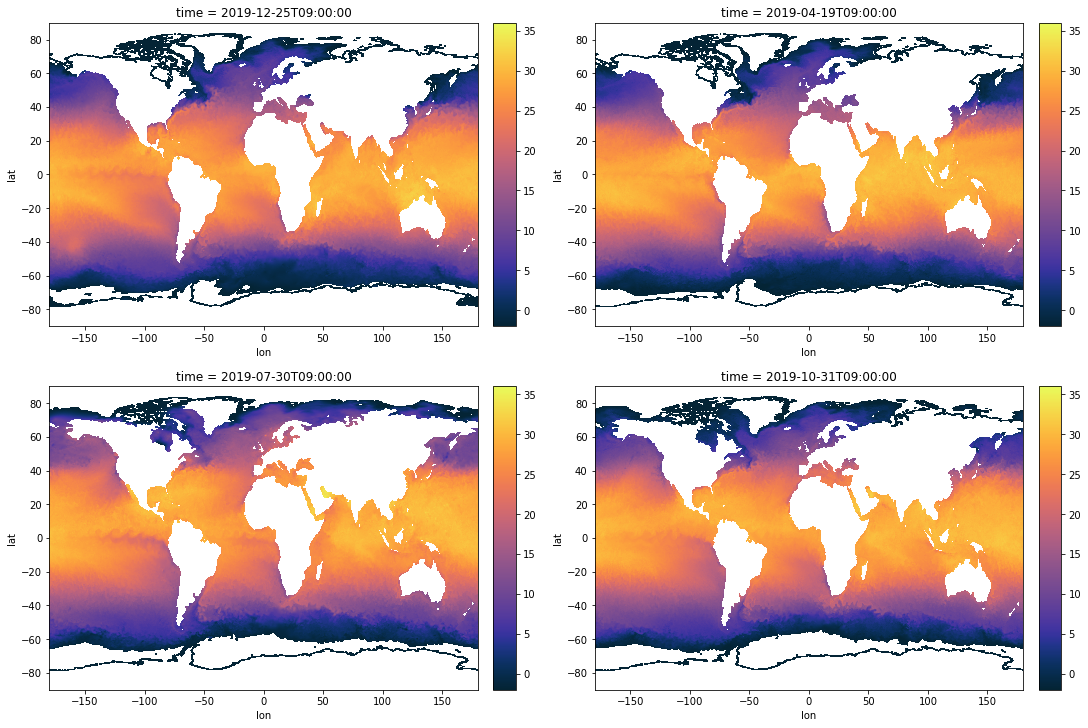

In [19]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,10),constrained_layout=True)
winterday.plot(ax=ax[0,0],cmap='cmo.thermal',vmin=-2,vmax=36)
springday.plot(ax=ax[0,1],cmap='cmo.thermal',vmin=-2,vmax=36)
summerday.plot(ax=ax[1,0],cmap='cmo.thermal',vmin=-2,vmax=36)
fallday.plot(ax=ax[1,1],cmap='cmo.thermal',vmin=-2,vmax=36)

### Step 4: Slice the dataset for desired regions (ATOMIC and LIS)

#### Let's slice the datasets for ATOMIC sampling area
##### Overall question: Has SST changed historically in the ATOMIC area. If so, how?

In [52]:
daily_sst = sst_masked.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_clima = daily_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_anom = daily_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_sst = sst_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_clima = monthly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_anom = monthly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_sst = sst_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_clima = yearly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_anom = yearly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
seasonal_clima = seasonal_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA = JJA.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_clima = JJA_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_anom = JJA_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
SON = SON.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_clima = SON_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_anom = SON_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF = DJF.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_clima = DJF_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_anom = DJF_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM = MAM.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_clima = MAM_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_anom = MAM_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

#### spatially average ATOMIC area and look at trends 

In [21]:
daily_spatial = daily_sst.mean(dim=('lon','lat')).load()

In [23]:
daily_anom_spatial = daily_anom.mean(dim=('lon','lat')).load()

In [24]:
monthly_spatial = monthly_sst.mean(dim=('lon','lat')).load()
monthly_anom_spatial = monthly_anom.mean(dim=('lon','lat')).load()

In [25]:
yearly_spatial = yearly_sst.mean(dim=('lon','lat')).load()
yearly_anom_spatial = yearly_anom.mean(dim=('lon','lat')).load()

In [26]:
daily_spatial = daily_spatial - 273.15
monthly_spatial = monthly_spatial - 273.15
yearly_spatial = yearly_spatial - 273.15

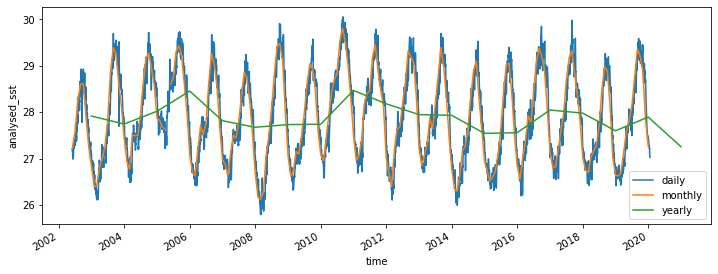

In [53]:
fig = plt.figure(figsize=(12,4))
daily_spatial.plot(label='daily')
monthly_spatial.plot(label='monthly')
yearly_spatial.plot(label='yearly')
plt.legend()

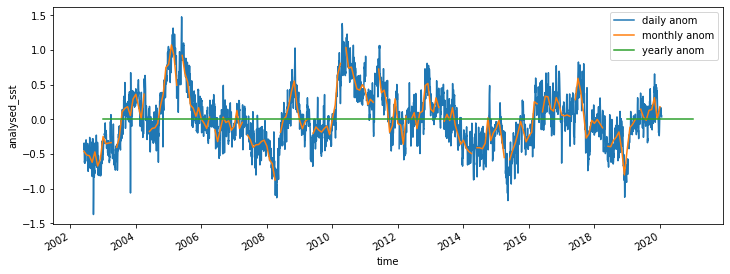

In [28]:
fig = plt.figure(figsize=(12,4))
daily_anom_spatial.plot(label='daily anom')
monthly_anom_spatial.plot(label='monthly anom')
yearly_anom_spatial.plot(label='yearly anom')
plt.legend()

### Seasonal Climatologies 

In [54]:
seasonal_clima.load();

In [55]:
seasonal_clima = seasonal_clima - 273.15

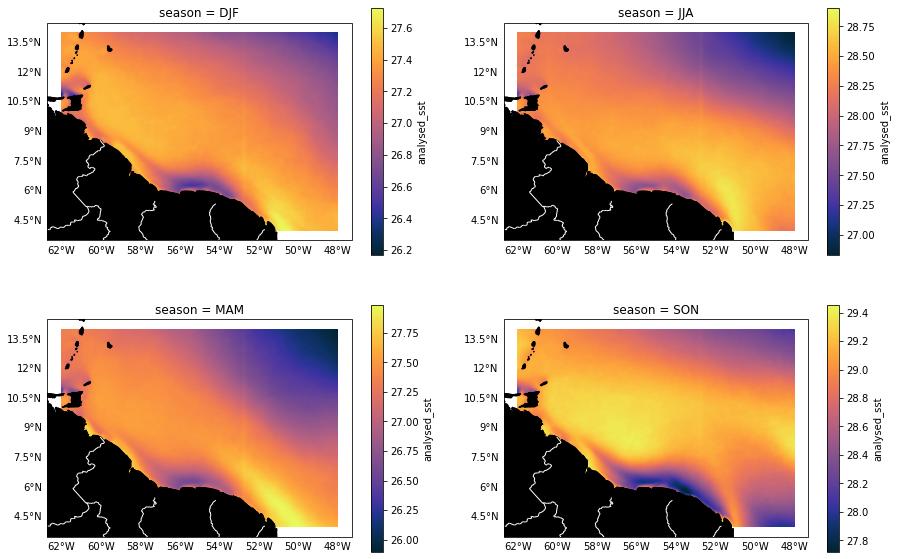

In [56]:
# Seasonal plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

seasonal_clima.isel(season=0).plot(ax=axs[0],**kw,zorder=0)
seasonal_clima.isel(season=1).plot(ax=axs[1],**kw,zorder=0)
seasonal_clima.isel(season=2).plot(ax=axs[2],**kw,zorder=0)
seasonal_clima.isel(season=3).plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

In [57]:
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'.load()')
    exec(season +'='+season+'-273.15')

In [58]:
seasons = ['JJA','DJF','MAM','SON']
for season in seasons:
    exec(season+'_clima.load()')
    exec(season +'_clima ='+season+'_clima -273.15')

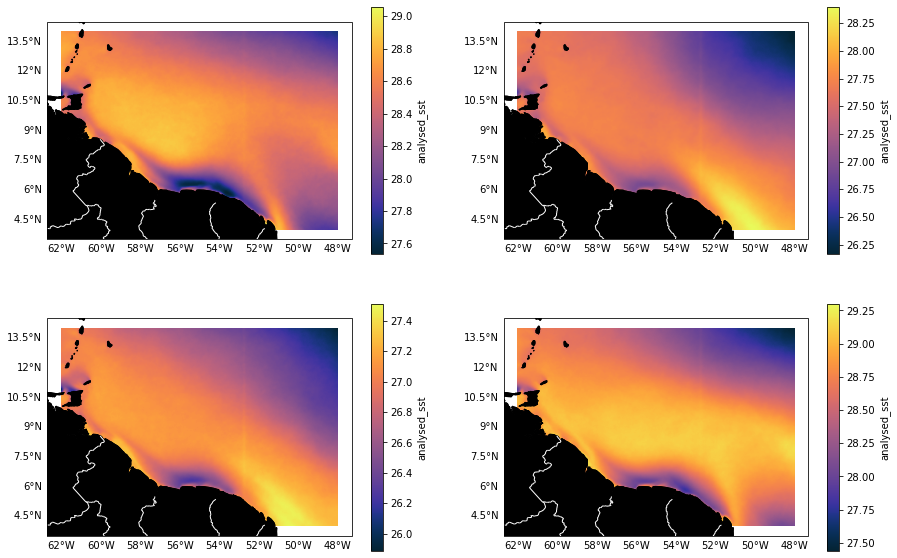

In [59]:
# Seasonal plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

DJF_clima.plot(ax=axs[0],**kw,zorder=0)
JJA_clima.plot(ax=axs[1],**kw,zorder=0)
MAM_clima.plot(ax=axs[2],**kw,zorder=0)
SON_clima.plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

In [60]:
JJA_spatial = JJA.mean(dim=('lat','lon'))
SON_spatial = SON.mean(dim=('lat','lon'))
DJF_spatial = DJF.mean(dim=('lat','lon'))
MAM_spatial = MAM.mean(dim=('lat','lon'))

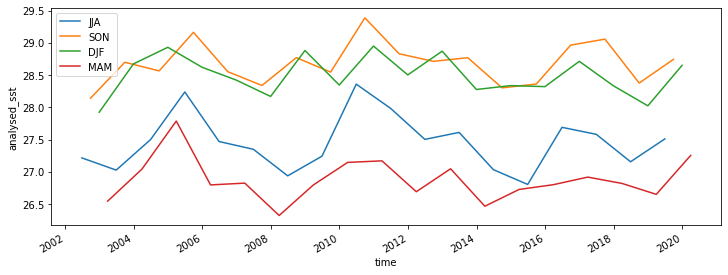

In [61]:
# take seasonal spatial averages and plot 
fig = plt.figure(figsize=(12,4))
JJA_spatial.plot(label='JJA')
SON_spatial.plot(label='SON')
DJF_spatial.plot(label='DJF')
MAM_spatial.plot(label='MAM')
plt.legend()

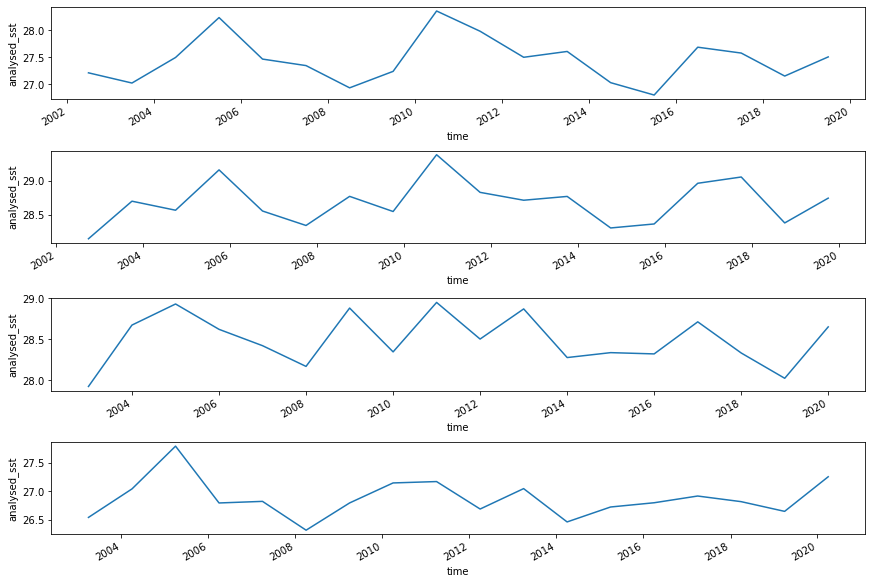

In [63]:
fig, ax = plt.subplots(ncols=1, nrows=4, constrained_layout=True, figsize=(12,8))
JJA_spatial.plot(label='JJA',ax=ax[0])
SON_spatial.plot(label='SON',ax=ax[1])
DJF_spatial.plot(label='DJF',ax=ax[2])
MAM_spatial.plot(label='MAM',ax=ax[3])

In [ ]:
SON_spatial.load()
MAM_spatial.load()
DJF_spatial.load()
JJA_spatial.load()

In [71]:
JJA_anom_spatial.load()
SON_anom_spatial.load()
DJF_anom_spatial.load()
MAM_anom_spatial.load()

<xarray.DataArray 'analysed_sst' (time: 18)>
array([-0.33292472,  0.16477628,  0.9086733 , -0.08124287, -0.0534621 ,
       -0.55551064, -0.0809484 ,  0.26778147,  0.29171315, -0.18675679,
        0.16876937, -0.41161397, -0.15140842, -0.07743595,  0.03977187,
       -0.05823667, -0.22751257,  0.37556756], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2003-03-31 2004-03-31 ... 2020-03-31

In [72]:
JJA_anom_spatial = JJA_anom.mean(dim=('lat','lon'))
SON_anom_spatial = SON_anom.mean(dim=('lat','lon'))
DJF_anom_spatial = DJF_anom.mean(dim=('lat','lon'))
MAM_anom_spatial = MAM_anom.mean(dim=('lat','lon'))

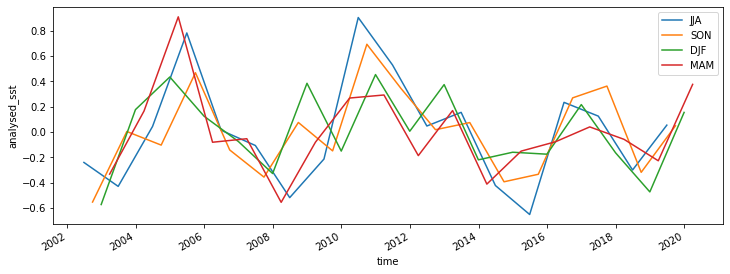

In [73]:
fig = plt.figure(figsize=(12,4))
JJA_anom_spatial.plot(label='JJA')
SON_anom_spatial.plot(label='SON')
DJF_anom_spatial.plot(label='DJF')
MAM_anom_spatial.plot(label='MAM')
plt.legend()

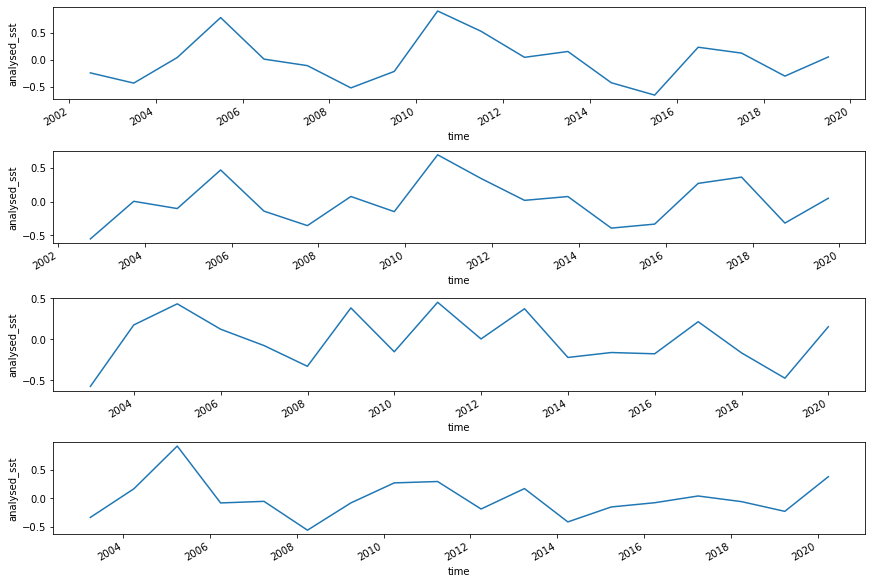

In [74]:
fig, ax = plt.subplots(ncols=1, nrows=4, constrained_layout=True, figsize=(12,8))
JJA_anom_spatial.plot(label='JJA',ax=ax[0])
SON_anom_spatial.plot(label='SON',ax=ax[1])
DJF_anom_spatial.plot(label='DJF',ax=ax[2])
MAM_anom_spatial.plot(label='MAM',ax=ax[3])

### stats

In [75]:
from scipy import signal

In [76]:
def calculate_trend(data_array):
    """
        This function estimates the linear trend of `sla` in a sea-level 
        dataset.
        
        Returns:
        
            - trend : float Sea-level trend in milimeters per year [mm/year].
    """
    
    sst_detrended = signal.detrend(data_array.values)
    
    trend = (data_array-sst_detrended).diff('time').mean().values/(1/12)  # trend in Deg[K]/year
    trend = np.round(trend,2)
    
    return trend

In [14]:
from scipy import stats

In [79]:
def get_stats(X):
    return [np.round(np.mean(X).values,2),np.round(np.min(X).values,2),np.round(np.max(X).values,2)]

In [82]:
JJA_spatial_stats = get_stats(JJA_spatial)
SON_spatial_stats = get_stats(SON_spatial)
MAM_spatial_stats = get_stats(MAM_spatial)
DJF_spatial_stats = get_stats(DJF_spatial)
yearly_spatial_stats = get_stats(yearly_spatial)

In [87]:
JJA_spatial_stats,SON_spatial_stats,MAM_spatial_stats,DJF_spatial_stats,yearly_spatial_stats

([27.46, 26.8, 28.36],
 [28.68, 28.14, 29.39],
 [26.88, 26.32, 27.79],
 [28.5, 27.92, 28.95],
 [27.87, 27.25, 28.47])

In [105]:
time_range=['JJA','SON','DJF','MAM','yearly']
for time in time_range:
    exec(time+'_dates = [str('+time+'_spatial[np.argmin('+time+'_spatial.values)].time.values)[:4],'
             'str('+time+'_spatial[np.argmax('+time+'_spatial.values)].time.values)[:4]]')

In [114]:
means = [DJF_spatial_stats[0],MAM_spatial_stats[0],JJA_spatial_stats[0],SON_spatial_stats[0],
        yearly_spatial_stats[0]]
mins = [DJF_spatial_stats[1],MAM_spatial_stats[1],JJA_spatial_stats[1],SON_spatial_stats[1],
       yearly_spatial_stats[1]]
min_year = [DJF_dates[0],MAM_dates[0],JJA_dates[0],SON_dates[0],
       yearly_dates[0]]
max_year = [DJF_dates[1],MAM_dates[1],JJA_dates[1],SON_dates[1],
       yearly_dates[1]]
maxs = [DJF_spatial_stats[2],MAM_spatial_stats[2],JJA_spatial_stats[2],SON_spatial_stats[2],
       yearly_spatial_stats[2]]
times = ['DJF','MAM','JJA','SON','Year']


In [115]:
df = pd.DataFrame(data=([times,means,mins,min_year,maxs,max_year]))

In [116]:
df = df.T

In [117]:
df = df.rename(columns={0:'Time Frame',1:'SST Mean',2:'SST Min',3:'Min Year',
                        4:'SST Max',5:'Max Year'})

In [118]:
df

,Time Frame,SST Mean,SST Min,Min Year,SST Max,Max Year
0,DJF,28.5,27.92,2002,28.95,2010
1,MAM,26.879999,26.32,2008,27.79,2005
2,JJA,27.459999,26.8,2015,28.36,2010
3,SON,28.68,28.14,2002,29.39,2010
4,Year,27.870001,27.25,2020,28.47,2010


### calculate trends 

In [127]:
from sklearn.linear_model import LinearRegression

In [129]:
x = np.arange(0,18,1)

In [130]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [141]:
np.polyfit?

Signature: np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
Docstring:
Least squares polynomial fit.

.. note::
   This forms part of the old polynomial API. Since version 1.4, the
   new polynomial API defined in `numpy.polynomial` is preferred.
   A summary of the differences can be found in the
   :doc:`transition guide </reference/routines.polynomials>`.

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error in the order `deg`, `deg-1`, ... `0`.

The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
method is recommended for new code as it is more stable numerically. See
the documentation of the method for more information.

Parameters
----------
x : array_like, shape (M,)
    x-coordinates of the M sample points ``(x[i], y[i])``.
y : array_like, shape (M,) or (M, K)
    y-coordinates of the sample points. Several data sets of sample
    poi

In [142]:
np.polyfit(x,JJA_spatial,deg=1)

array([-2.52625079e-03,  2.74773023e+01])

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle